## `process_end_time`（ユニット）ごとのOV推移を時系列出力

- **ユニット定義**: 同一の `process_end_time` を同一ユニットとして扱う
- **時系列**: ユニット内を `final_mes_time` の昇順に並べたOVの推移
- **出力**:
  - 長形式: `data/processed/ov_timeseries_by_unit.csv`
  - ユニット集計: 件数/期間/OV統計
  - 代表ユニットの推移プロット（上位Nユニット）

In [364]:
cluster_num = 4

In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display
import pathlib
import tqdm
import optuna

from scipy.cluster.hierarchy import linkage, dendrogram
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

from seaborn_analyzer import regplot
from lightgbm import LGBMRegressor

from utils.mmd import mmd_rbf_unbiased
from utils.slicedWassersteinDistance import sliced_wasserstein_distance

import xgboost as xgb
from xgboost import XGBRegressor

In [366]:
raw_data = pd.read_excel('../data/raw/kadai.xlsx')
raw_data.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [367]:
train = raw_data[:-500]
train.tail()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
1771,2016-11-28 07:26:00,2017-01-18 09:43:00,107.8289,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.2,0.0,2.7,0.02,0.01,0.25,0.04
1772,2016-11-28 07:26:00,2017-01-18 12:34:00,127.8525,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.2,0.0,2.7,0.02,0.01,0.25,0.04
1773,2016-11-28 07:26:00,2017-01-18 13:42:00,116.4156,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.2,0.0,2.7,0.02,0.01,0.25,0.04
1774,2016-11-28 07:26:00,2017-01-18 14:47:00,131.6603,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.2,0.0,2.7,0.02,0.01,0.25,0.04
1775,2016-11-28 07:26:00,2017-01-18 16:38:00,123.1508,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.03,0.26,6.5,0.2,0.0,2.7,0.02,0.01,0.25,0.04


In [368]:
train = train.copy()
train["batch_id"] = train.groupby("process_end_time").ngroup()
train.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X75,X76,X77,X78,X79,X80,X81,X82,X83,batch_id
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0


## `batch_id==43`のデータの`std`がNaNになっている(レコード数1だから)

In [369]:
train.query("batch_id == 43").describe().T

,count,mean,min,25%,50%,75%,max,std
process_end_time,25,2016-10-11 20:55:00,2016-10-11 20:55:00,2016-10-11 20:55:00,2016-10-11 20:55:00,2016-10-11 20:55:00,2016-10-11 20:55:00,NaN
final_mes_time,25,2016-11-23 05:26:09.600000256,2016-11-21 11:54:00,2016-11-21 19:44:00,2016-11-22 00:17:00,2016-11-22 08:04:00,2016-11-27 20:32:00,NaN
OV,25.0,116.364666,72.25858,97.68092,113.827,131.5234,182.1575,26.804585
X1,25.0,22.5632,21.96,21.96,23.12,23.12,23.12,0.591486
X2,25.0,2.0412,1.23,1.23,2.79,2.79,2.79,0.795447
...,...,...,...,...,...,...,...,...
X80,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X81,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X82,25.0,0.23,0.23,0.23,0.23,0.23,0.23,0.0
X83,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


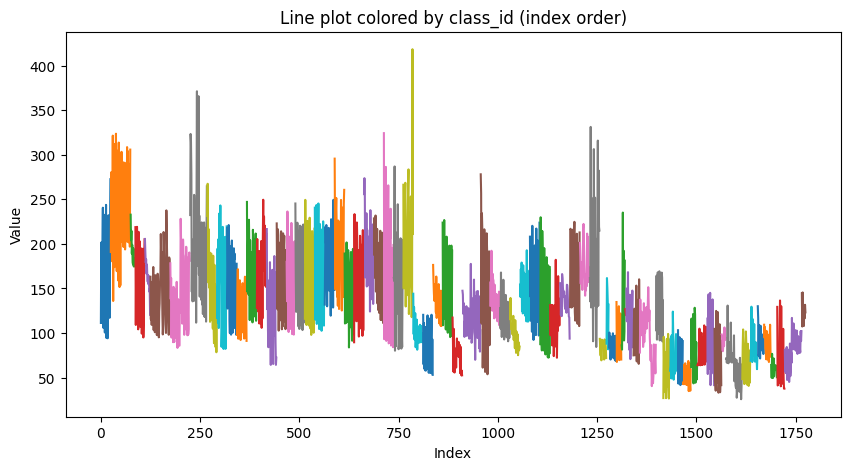

In [370]:
plt.figure(figsize=(10, 5))

for batch_id, g in train.groupby("batch_id"):
    plt.plot(
        g.index,
        g["OV"],
        label=f"batch {batch_id}"
    )

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line plot colored by class_id (index order)")
plt.show()

In [371]:
group_max = train["batch_id"].max()
group_max

75

In [372]:
target_cols = ["OV"]
train_group_describe = train.groupby("batch_id")[target_cols].describe()
train_group_describe.columns = [f"{col}_{stat}" for col, stat in train_group_describe.columns]

# 4) batch_id 0〜99 を揃える（欠番があっても行が揃う）
train_group_describe = train_group_describe.reindex(range(group_max +1))

train_group_describe.shape

(76, 8)

In [373]:
train_group_describe.head()

,OV_count,OV_mean,OV_std,OV_min,OV_25%,OV_50%,OV_75%,OV_max
batch_id,,,,,,,,
0,25.0,173.095301,53.414865,94.09462,117.061900,186.44740,207.502800,272.5857
1,50.0,241.289936,52.090579,135.92270,201.864800,237.02915,287.242875,323.5988
2,12.0,192.000583,18.030431,174.63060,178.607950,186.47455,200.182675,232.7684
3,24.0,163.060428,42.699022,94.99309,120.429150,178.57250,195.746475,219.1410
4,14.0,165.873057,20.871967,120.42570,155.393125,164.31325,178.399150,205.5169


<Axes: ylabel='batch_id'>

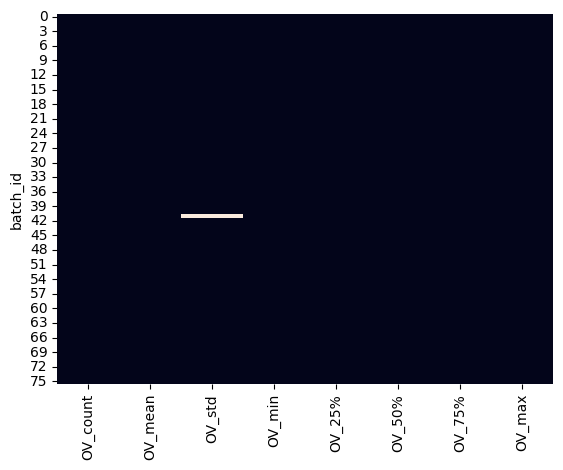

In [374]:
X= train_group_describe
sns.heatmap(X.isna(), cbar=False)

In [375]:
X.tail(3)

,OV_count,OV_mean,OV_std,OV_min,OV_25%,OV_50%,OV_75%,OV_max
batch_id,,,,,,,,
73,19.0,71.020897,36.507742,37.50772,42.377095,50.41835,102.96480,136.4957
74,43.0,80.479239,17.281147,45.09756,75.760615,82.12382,90.23184,116.9339
75,10.0,123.481890,13.949862,107.27810,112.033275,121.57735,130.70835,145.5511


In [376]:
# 欠損補完は前後の値の平均で（線形補間使用）
X.interpolate(method='linear', axis=0, inplace=True, limit_direction='both')

In [377]:
model = AgglomerativeClustering(
    n_clusters=cluster_num,
    metric="euclidean",
    linkage="ward"
)

model.fit(X)

AgglomerativeClustering(n_clusters=4)

In [378]:
len(model.labels_)

76

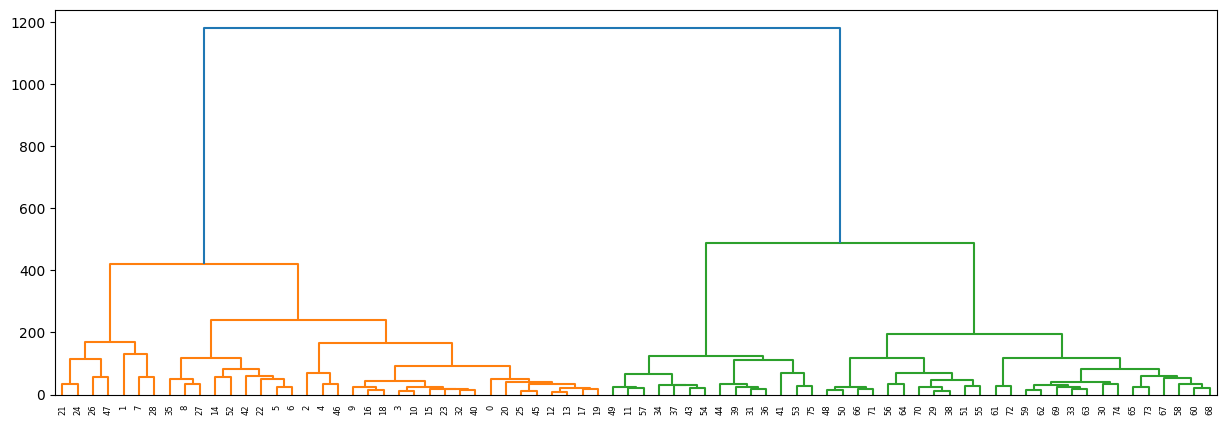

In [379]:
# リンク関数で階層構造を生成（'ward'はユークリッド距離限定）
linked = linkage(X, method='ward')

plt.figure(figsize=(15, 5))
dendrogram(linked, labels=X.index)
plt.show()

In [380]:
X["labels"] = model.labels_
X

,OV_count,OV_mean,OV_std,OV_min,OV_25%,OV_50%,OV_75%,OV_max,labels
batch_id,,,,,,,,,
0,25.0,173.095301,53.414865,94.09462,117.061900,186.44740,207.502800,272.58570,0
1,50.0,241.289936,52.090579,135.92270,201.864800,237.02915,287.242875,323.59880,3
2,12.0,192.000583,18.030431,174.63060,178.607950,186.47455,200.182675,232.76840,0
3,24.0,163.060428,42.699022,94.99309,120.429150,178.57250,195.746475,219.14100,0
4,14.0,165.873057,20.871967,120.42570,155.393125,164.31325,178.399150,205.51690,0
...,...,...,...,...,...,...,...,...,...
71,18.0,89.303027,13.572619,67.48009,79.973772,90.89747,97.881782,109.29320,1
72,15.0,59.426841,7.920872,49.45166,52.418065,59.15161,63.681500,76.60797,1
73,19.0,71.020897,36.507742,37.50772,42.377095,50.41835,102.964800,136.49570,1


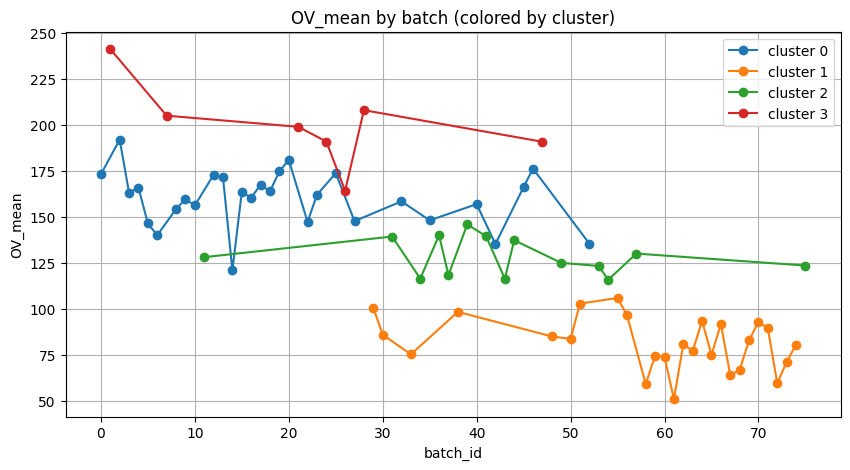

In [381]:
plt.figure(figsize=(10, 5))

for label, g in X.groupby("labels"):
    plt.plot(
        g.index,          # batch_id
        g["OV_mean"],     # 代表値（mean）
        marker="o",
        linestyle="-",
        label=f"cluster {label}"
    )

plt.xlabel("batch_id")
plt.ylabel("OV_mean")
plt.title("OV_mean by batch (colored by cluster)")
plt.legend()
plt.grid(True)
plt.show()

In [382]:
train = train.merge(
    X[["labels"]],      # 付与したい列だけ
    left_on="batch_id",
    right_index=True,   # X は index が batch_id
    how="left"
)

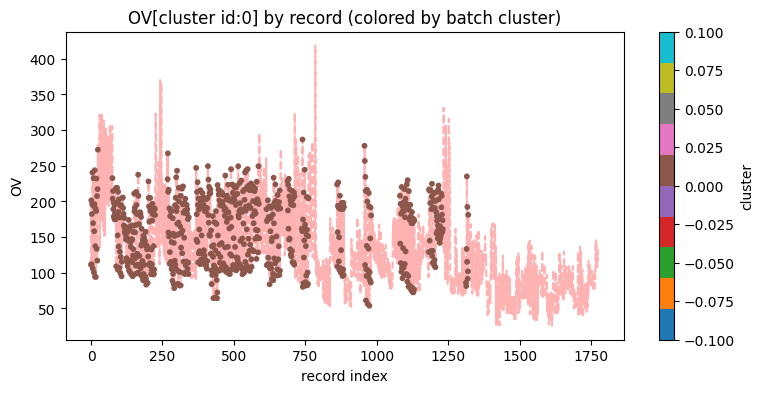

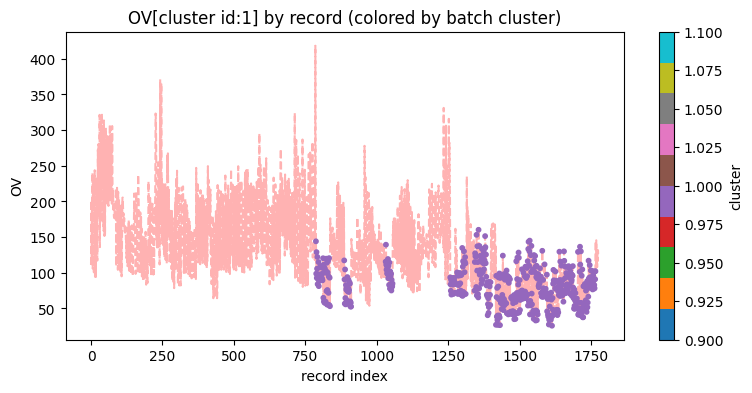

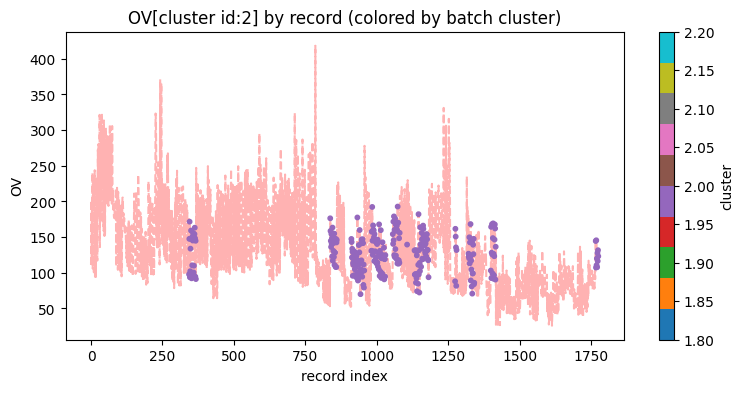

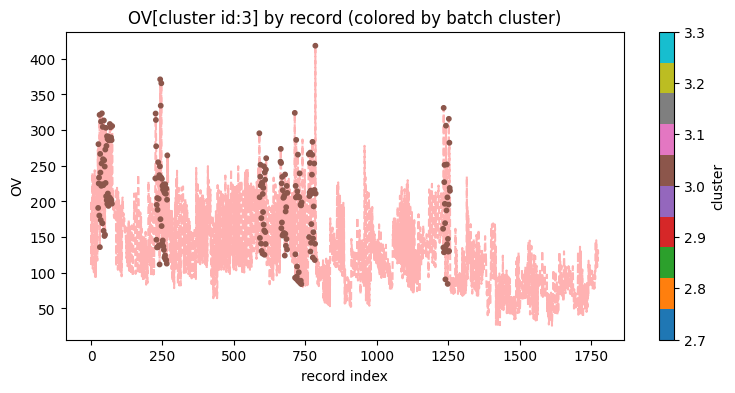

In [383]:
for i in range(cluster_num):
    plt.figure(figsize=(9, 4))
    plt.plot(
        train.index,
        train["OV"],
        label='Actual OV',
        color='red',
        linestyle='--',
        alpha=0.3
    )
    # labelsが1のみフィルタしてプロット
    mask = train["labels"] == i
    plt.scatter(
        train.index[mask],
        train["OV"][mask],
        c=train["labels"][mask],
        cmap="tab10",
        s=10,
        zorder=2
    )

    plt.xlabel("record index")
    plt.ylabel("OV")
    plt.title(f"OV[cluster id:{i}] by record (colored by batch cluster)")
    plt.colorbar(label="cluster")

    plt.show()

## trainデータにおけるクラス予測(説明変数: OV以外)

In [384]:
train.head(3)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X76,X77,X78,X79,X80,X81,X82,X83,batch_id,labels
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,0
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,0
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,0


In [385]:
train_one_hot_encording = pd.get_dummies(train, drop_first=False, columns=['labels'])
train_one_hot_encording.head(3)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X79,X80,X81,X82,X83,batch_id,labels_0,labels_1,labels_2,labels_3
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,True,False,False,False
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,4.1,0.0,0.01,0.16,0.04,0,True,False,False,False
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,4.1,0.0,0.01,0.16,0.04,0,True,False,False,False



==== label_0 ============================================================
y overall:
 labels_0
0    1049
1     727
Name: count, dtype: int64
y train:
 labels_0
0    734
1    509
Name: count, dtype: int64
y test:
 labels_0
0    315
1    218
Name: count, dtype: int64
confusion matrix:
 [[310   5]
 [  7 211]]
              precision    recall  f1-score   support

           0      0.978     0.984     0.981       315
           1      0.977     0.968     0.972       218

    accuracy                          0.977       533
   macro avg      0.977     0.976     0.977       533
weighted avg      0.977     0.977     0.977       533



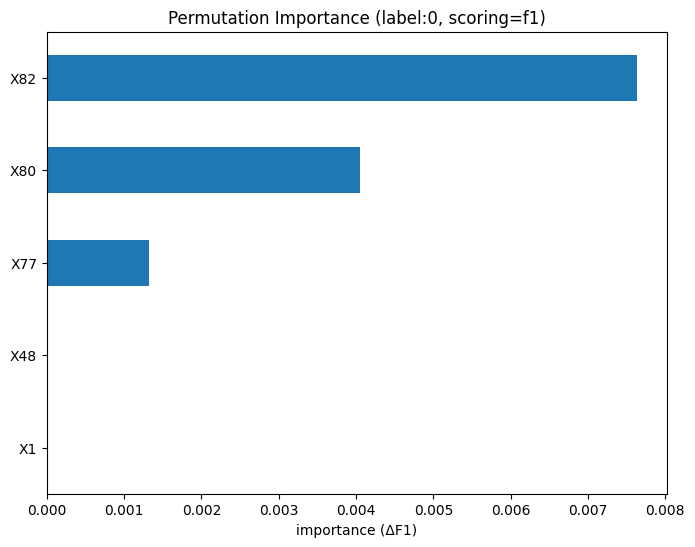


==== label_1 ============================================================
y overall:
 labels_1
0    1221
1     555
Name: count, dtype: int64
y train:
 labels_1
0    855
1    388
Name: count, dtype: int64
y test:
 labels_1
0    366
1    167
Name: count, dtype: int64
confusion matrix:
 [[366   0]
 [  0 167]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       366
           1      1.000     1.000     1.000       167

    accuracy                          1.000       533
   macro avg      1.000     1.000     1.000       533
weighted avg      1.000     1.000     1.000       533



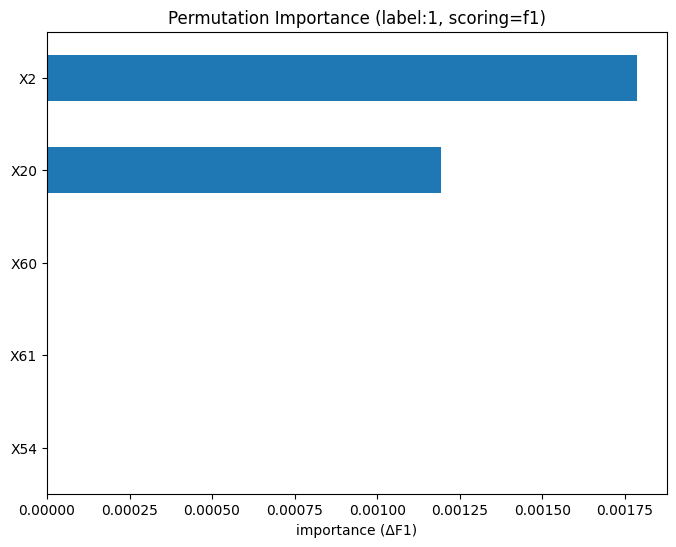


==== label_2 ============================================================
y overall:
 labels_2
0    1500
1     276
Name: count, dtype: int64
y train:
 labels_2
0    1050
1     193
Name: count, dtype: int64
y test:
 labels_2
0    450
1     83
Name: count, dtype: int64
confusion matrix:
 [[450   0]
 [  0  83]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       450
           1      1.000     1.000     1.000        83

    accuracy                          1.000       533
   macro avg      1.000     1.000     1.000       533
weighted avg      1.000     1.000     1.000       533



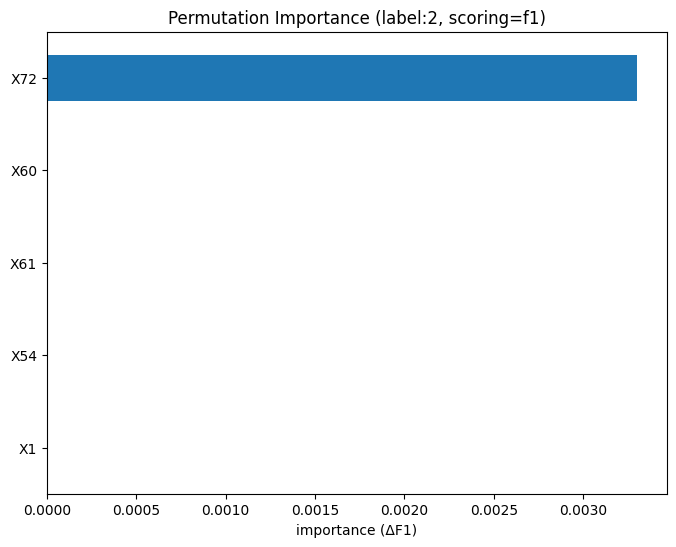


==== label_3 ============================================================
y overall:
 labels_3
0    1558
1     218
Name: count, dtype: int64
y train:
 labels_3
0    1090
1     153
Name: count, dtype: int64
y test:
 labels_3
0    468
1     65
Name: count, dtype: int64
confusion matrix:
 [[459   9]
 [  0  65]]
              precision    recall  f1-score   support

           0      1.000     0.981     0.990       468
           1      0.878     1.000     0.935        65

    accuracy                          0.983       533
   macro avg      0.939     0.990     0.963       533
weighted avg      0.985     0.983     0.984       533



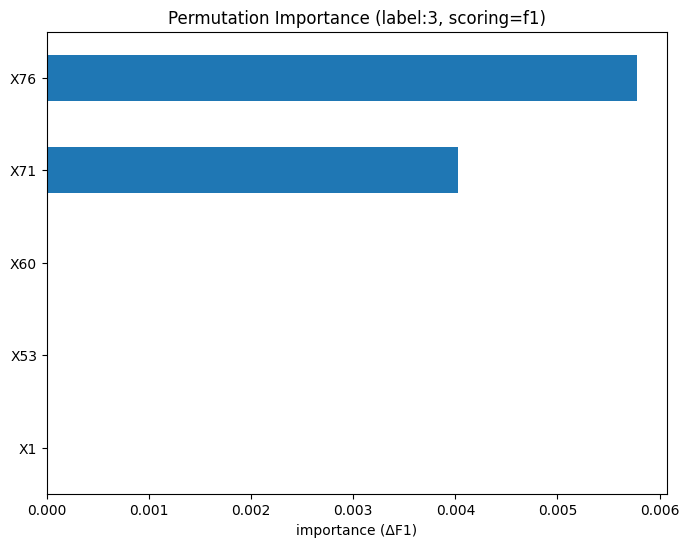

{0: {'X82': 0.007638213849114289,
  'X80': 0.0040565049385662185,
  'X77': 0.0013256140155864682,
  'X1': 0.0,
  'X48': 0.0},
 1: {'X2': 0.0017883795309168505,
  'X20': 0.0011931414356787574,
  'X54': 0.0,
  'X61': 0.0,
  'X60': 0.0},
 2: {'X72': 0.003304343433302398,
  'X1': 0.0,
  'X54': 0.0,
  'X61': 0.0,
  'X60': 0.0},
 3: {'X76': 0.005782287754652599,
  'X71': 0.004021534205420752,
  'X1': 0.0,
  'X53': 0.0,
  'X60': 0.0}}

In [406]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

perm_importances = {}

for label_ in range(cluster_num):
    print(f"\n==== label_{label_} ============================================================")

    ignore_labels = [f"labels_{i}" for i in range(cluster_num)]
    ignore_cols = ['OV', "process_end_time", "final_mes_time", "batch_id", *ignore_labels]

    X = train_one_hot_encording.drop(columns=ignore_cols)
    y = train_one_hot_encording[f'labels_{label_}'].astype(int)  # bool→0/1に統一

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=42
    )

    print("y overall:\n", y.value_counts())
    print("y train:\n", y_train.value_counts())
    print("y test:\n", y_test.value_counts())

    model = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"   # 不均衡対策（効くこと多い）
    )
    model.fit(X_train, y_train)

    # 評価（分類）
    y_pred = model.predict(X_test)
    print("confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))

    # Permutation Importance（分類スコアで・テストで）
    r = permutation_importance(
        model,
        X_test, y_test,
        n_repeats=20,
        random_state=42,
        n_jobs=-1,
        scoring="f1"   # ここが重要（precision/recallでもOK）
    )

    perm = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(8, 6))
    perm.head(5).sort_values().plot.barh()
    plt.title(f"Permutation Importance (label:{label_}, scoring=f1)")
    plt.xlabel("importance (ΔF1)")
    plt.show()

    perm_importances[label_] = perm.head(5).to_dict()

perm_importances